# Cats vs Dogs - Deep Learning

## 1. Data Preprocessing and Visualisation

In [16]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

#### Global Variables:

In [17]:
path_to_data = "./train/"
img_list = os.listdir(path_to_data)

#### Let us visualise a random picture from the training set

In [18]:
print img_list[0][:3]

cat


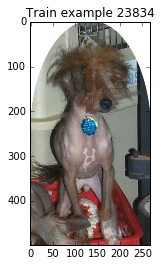

(499, 268, 3)


In [19]:
n = np.random.randint(0,25000)
img = plt.imread(path_to_data+img_list[n])

plt.figure()
plt.title("Train example %d"%n)
plt.imshow(img)
plt.show()

print img.shape

#### An overview of the data we are dealing with:

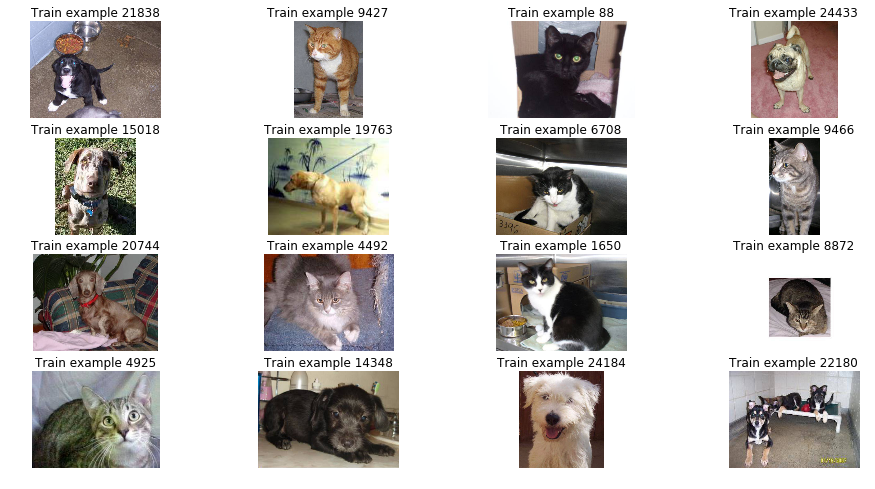

In [20]:
n = np.random.randint(0,25000,16)

plt.figure(figsize=(16,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title("Train example %d"%n[i])
    img = plt.imread(path_to_data+img_list[n[i]])
    plt.axis("off")
    plt.imshow(img)
plt.show()

### Image Stats 

In [22]:
width_histogram = []
height_histogram = []
i = 0
for name in img_list:
    img = plt.imread(path_to_data+name)
    width_histogram.append(img.shape[1])
    height_histogram.append(img.shape[0])
    print "\r%d"%i, 
    i += 1

24999


In [23]:
print "Mean width :", np.mean(width_histogram)
print "Mean height :", np.mean(height_histogram)

Mean width : 404.09904
Mean height : 360.47808


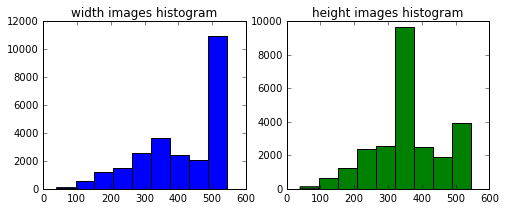

Mean width : 404.09904
Mean height : 360.47808


In [24]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title("width images histogram")
plt.hist(width_histogram, range=(40,600))
plt.subplot(1,2,2)
plt.title("height images histogram")
plt.hist(height_histogram, range=(40,600), color="g")
plt.show()

print "Mean width :", np.mean(width_histogram)
print "Mean height :", np.mean(height_histogram)

## Data manipulation

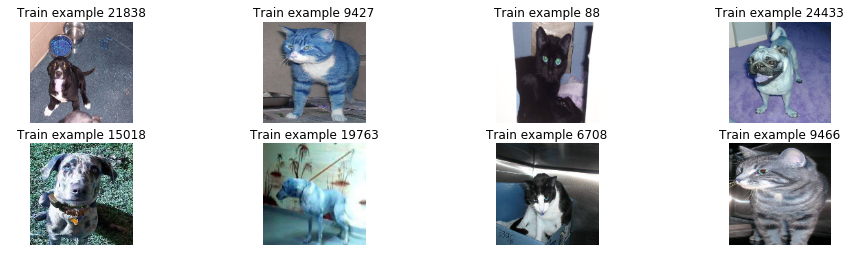

In [25]:
sz = (150,150)
plt.figure(figsize=(16,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title("Train example %d"%n[i])
    img = cv2.imread(path_to_data+img_list[n[i]])
    b,g,r = cv2.split(img)
    resized_img1 = cv2.resize(b, sz)
    resized_img2 = cv2.resize(g, sz)
    resized_img3 = cv2.resize(r, sz)
    resized_img = cv2.merge((resized_img1,resized_img2,resized_img3))
    plt.axis("off")
    plt.imshow(resized_img)
plt.show()

In [26]:
import PIL

def remove_black_borders_from_rotation(rotated_img, deg):
    
    if deg<0:
        out = remove_black_borders_from_rotation(rotated_img[:,::-1], -deg)
        return out[:,::-1]
    
    row, col = rotated_img.shape

    first_row = rotated_img[0]
    first_col = rotated_img[:,0]

    cropx = np.argwhere(np.cumsum(first_row[::-1]!=0)==1)[0][0]
    cropy = np.argwhere(np.cumsum(first_col!=0)==1)[0][0]
    
    return rotated_img[cropy:(row-cropy), cropx:(col-cropx)]

def remove_black_borders_from_translation(translated_img, tx, ty):
    
    row, col = translated_img.shape
    
    left = max(0,tx)
    right = min(col,col+tx)
    up = max(0,ty)
    down = min(row,row+ty)
    
    return translated_img[up:down, left:right]

def rotate(img, angle):
    # if img.ndim > 2:
    #     print "Rotate only works for gray image."
    # rows,cols = img.shape
    # M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    # return cv2.warpAffine(img, M,(cols,rows))
    pil_img = PIL.Image.fromarray(img)
    return np.array(pil_img.rotate(angle), dtype=img.dtype)

def crop(img, crop_rates):
    rows,cols = img.shape
    crop_up, crop_down, crop_left, crop_right = crop_rates
    crop_up = int(crop_up*rows/100.0)
    crop_down = int(crop_down*rows/100.0)
    crop_left = int(crop_left*rows/100.0)
    crop_right = int(crop_right*rows/100.0)
    return img[crop_up:(rows-crop_down),crop_left:(cols-crop_right)]

def resize_and_scale(img, size, scale):
    img = cv2.resize(img, size)
    return np.array(img, "float32")/scale

In [41]:
def rotate_crop_and_scale(img, final_size, max_angle, max_crop_rate, scale):
    # Random Rotation
    angle = np.random.randint(-max_angle,max_angle)
    # Random Crop
    crop_rates = np.random.randint(0, max_crop_rate, 4) # translation rates
    
    b,g,r = cv2.split(img)
    resized_channels = []
    rotated_channels = []
    cropped_channels = []
    cropped_rotated_channels = []
    for img_channel in [b,g,r]:
        rotated_img = rotate(img_channel, angle)
        rotated_channels.append(rotated_img)

        # Remove black borders
        cropped_rotated_img = remove_black_borders_from_rotation(rotated_img, angle)
        cropped_rotated_channels.append(cropped_rotated_img)
        cropped_img = crop(cropped_rotated_img, crop_rates)
        cropped_channels.append(cropped_img)
        # Resize and scale
        resized_img = resize_and_scale(cropped_img, final_size, scale)
        resized_channels.append(resized_img)
    
#     rotated_img = cv2.merge((rotated_channels[0],rotated_channels[1],rotated_channels[2]))
#     cropped_rotated_img = cv2.merge((cropped_rotated_channels[0],cropped_rotated_channels[1],cropped_rotated_channels[2]))
#     cropped_img = cv2.merge((cropped_channels[0],cropped_channels[1],cropped_channels[2]))
    resized_img = cv2.merge((resized_channels[0],resized_channels[1],resized_channels[2]))
    # Flip left right
    
    if np.random.randint(0,2)==1:
        resized_img = np.fliplr(resized_img)
    output_img = resized_img
    # Return
#     return output_img, cropped_img, cropped_rotated_img, rotated_img, angle
    return output_img

def display_process(str_file, sz=(150,150)): 
    img = cv2.imread(str_file)
    output_img, cropped_im, cropped_rotated_img, rotated_img, angle = rotate_crop_and_scale(img, sz, 10, 10, 255.0)
    # DISPLAY
    plt.figure(figsize=(16,10))
    plt.subplot(2,3,1)
    plt.axis("off")
    plt.title("Raw (%dx%d)"%(img.shape[0],img.shape[1]))
    plt.imshow(img, interpolation="nearest")
    plt.subplot(2,3,2)
    plt.axis("off")
    plt.title("Rotated (%d deg)"%angle)
    plt.imshow(rotated_img, interpolation="nearest")
    plt.subplot(2,3,3)
    plt.axis("off")
    plt.title("Without black border")
    plt.imshow(cropped_rotated_img, interpolation="nearest")
    plt.subplot(2,3,4)
    plt.axis("off")
    plt.title("Random crop")
    plt.imshow(cropped_im, interpolation="nearest")
    plt.subplot(2,3,5)
    plt.axis("off")
    plt.title("Final image")
    plt.imshow(output_img, interpolation="nearest")
    plt.show()

In [42]:
def preprocess(str_file, sz=(150,150)):
    try:
        img = cv2.imread(str_file)
        output_img = rotate_crop_and_scale(img, sz, 10, 10, 255.0)
        return output_img
    except Exception as e:
        raise str(e)

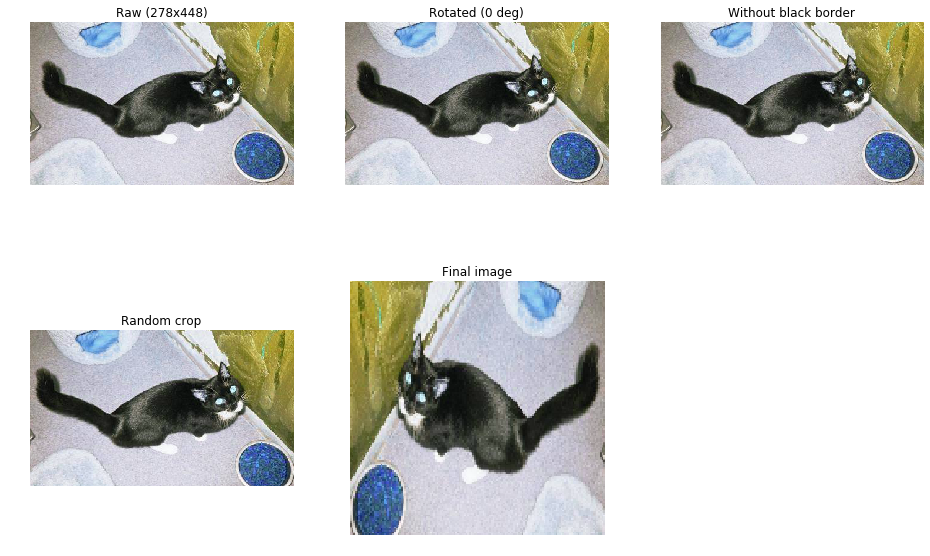

In [29]:
n = np.random.randint(0,25000,1)[0]
display_process(path_to_data+img_list[n], sz=(150,150))

## Split Data - Training and Validation Set

In [30]:
np.random.seed(123456)
index = np.arange(0,25000,1)
np.random.shuffle(index)

In [31]:
img_list = np.array(img_list)
train_list = img_list[index[0:20000]] # 20000 train examples
valid_list = img_list[index[20000:25000]] # 5000 valid examples

# Targets
targets = np.zeros((25000,2))
targets[0:12500,0]=1.0
targets[12500:25000,1]=1.0
train_targets = targets[index[0:20000]]
valid_targets = targets[index[20000:25000]]

### Storing the Training Set

In [43]:
final_size = (150,150)
# Instantiate train data
train_data = np.zeros((20000, final_size[0], final_size[1], 3), dtype="float32")
# Fill it
for i, name in enumerate(train_list):
    try:
        train_example = preprocess(path_to_data+name, final_size)
        train_data[i] = train_example
        print "\r%d examples processed"%(i+1),
    except Exception as e:
        print str(e)

358 examples processed exceptions must be old-style classes or derived from BaseException, not str
6694 examples processed exceptions must be old-style classes or derived from BaseException, not str
10033 examples processed exceptions must be old-style classes or derived from BaseException, not str
19885 examples processed exceptions must be old-style classes or derived from BaseException, not str
20000 examples processed


In [48]:
import cPickle
description = "Training data. Rotation : +- 10 deg. Translation rate : +-15. Norm : (x - mean(x))/128.0"
with open('/Volumes/Untitled 1/Backup/Mac/cats_vs_dogs_data/train_data_2016_12_18.pkl', 'w') as f:
    cPickle.dump(train_data, f)
    cPickle.dump(description, f)

In [49]:
description = "Training labels.[1 0]- cats, [0 1]- dogs"
with open('/Volumes/Untitled 1/Backup/Mac/cats_vs_dogs_data/train_labels_2016_12_18.pkl', 'w') as f:
    cPickle.dump(train_targets, f)
    cPickle.dump(description, f)

In [61]:
valid_data = np.zeros((5000, final_size[0], final_size[1], 3), dtype="float32")
# Fill it
for i, name in enumerate(valid_list):
    try:
        valid_example = preprocess(path_to_data+str(name), final_size)
        valid_data[i] = valid_example
        print "\r%d examples processed"%(i+1),
    except Exception as e:
        print e

3858 examples processed exceptions must be old-style classes or derived from BaseException, not str
5000 examples processed


In [62]:
description = "Valid data. Rotation : +- 10 deg. Translation rate : +-15. Norm : (x - mean(x))/128.0"
with open('/Volumes/Untitled 1/Backup/Mac/cats_vs_dogs_data/valid_data_2016_12_18.pkl', 'w') as f:
    cPickle.dump(valid_data, f)
    cPickle.dump(description, f)

In [63]:
description = "Validation labels.[1 0]- cats, [0 1]- dogs"
with open('/Volumes/Untitled 1/Backup/Mac/cats_vs_dogs_data/valid_labels_2016_12_18.pkl', 'w') as f:
    cPickle.dump(valid_targets, f)
    cPickle.dump(description, f)

In [64]:
with open('/Volumes/Untitled 1/Backup/Mac/cats_vs_dogs_data/valid_data_2016_12_18.pkl', 'r') as f:
    valid_data = cPickle.load(f)

In [65]:
with open('/Volumes/Untitled 1/Backup/Mac/cats_vs_dogs_data/valid_labels_2016_12_18.pkl', 'r') as f:
    valid_labels = cPickle.load(f)    

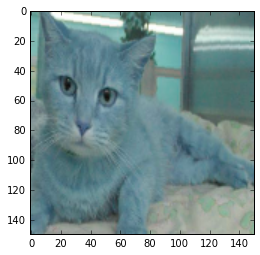

[ 1.  0.]


In [67]:
plt.imshow(valid_data[-1])
plt.show()
print valid_labels[-1]